<a href="https://colab.research.google.com/github/M-Amrollahi/Personal-Notes/blob/master/ML-notes/gradient_tracking_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import sklearn.metrics as metr
from sklearn.decomposition import PCA

In [29]:
dsmnist = datasets.MNIST("./",download=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(dsmnist.data, dsmnist.targets,test_size=.1,stratify=dsmnist.targets)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.05, stratify=y_test)

In [31]:
class cls_data(Dataset):
    
    def __init__(self, x, y):
        super().__init__()
        self.data = x
        self.target = y
    def __len__(self):
        return len(self.target)
    def __getitem__(self, index) :
        return self.data[index].unsqueeze(dim=0), self.target[index]


In [32]:
ds_train = cls_data(X_train/255., y_train)
ds_test = cls_data(X_test/255., y_test)
ds_val = cls_data(X_val/255.,y_val)

train_loader = DataLoader(ds_train,batch_size=16)
test_loader = DataLoader(ds_test,batch_size=16)
val_loader = DataLoader(ds_val,batch_size=16)

In [99]:
from collections import OrderedDict
class cls_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model_feature = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(in_channels=1,out_channels=3,kernel_size=(3,3))),
            ("maxp1", nn.MaxPool2d(2,2))]))
        
        self.model_classify = nn.Sequential(OrderedDict([
            ("linear1",nn.Linear(13*13*3,500)),
            ("relu1",nn.ReLU()),
            ("layernorm1",nn.LayerNorm(500)),
            ("dropout1", nn.Dropout(p=.1)),
            ("linear2",nn.Linear(500,10))]
        ))

        #torch.nn.init.ones_(self.model_classify[0].weight.data)
        
        #self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=3,kernel_size=(3,3))
        #self.maxp = torch.nn.MaxPool2d(2,2)
        #self.l1 = torch.nn.Linear(13*13*3,500)
        #self.lnorm1 = torch.nn.LayerNorm(500)
        #self.relu1 = torch.nn.ReLU()
        #self.drop1 = torch.nn.Dropout(p=.1)
        #self.l2 = torch.nn.Linear(500,10)

    def forward(self, x):
        #x = torch.permute(x,()
        #x = self.conv1(x)
        #x = self.maxp(x)
        x = self.model_feature.forward(x)

        x = x.reshape((x.shape[0],-1))
        
        y = self.model_classify(x)
        #y = self.l2.forward(self.drop1( self.lnorm1(self.relu1( self.l1.forward(x)))))

        return y

    def f_getGrads(self):
        return self.model_classify[0].weight.grad.detach().clone().mean(dim=1).numpy()

In [100]:
model = cls_model()
model
#model.forward(X_train[:5]/255.)

cls_model(
  (model_feature): Sequential(
    (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (model_classify): Sequential(
    (linear1): Linear(in_features=507, out_features=500, bias=True)
    (relu1): ReLU()
    (layernorm1): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [101]:
def f_validate(model, dloader, criterion):
    model.eval()
    preds = torch.empty(0)
    targets = torch.empty(0)

    tmpLoss = 0
    for i , (x_batch, y_batch) in enumerate(dloader):
        y_pred = model.forward(x_batch)
        preds = torch.cat((preds, y_pred.argmax(dim=1)))
        targets = torch.cat((targets,y_batch))

        tmpLoss += criterion(y_pred, y_batch).item() / len(y_batch)
        #lst_pred.append( [y_pred.argmax(dim=1),y_batch])
    
    return targets.detach().numpy(), preds.detach().numpy() , tmpLoss

In [102]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 10

dict_grads = dict()
dict_res = dict()
for i in range(epochs):
    tmpLoss = 0.
    for j,(x_batch, y_batch) in enumerate(train_loader):

        y_pred = model.forward(x_batch)
        #print(y_pred.shape)
        #print(y_batch.unsqueeze(dim=1).shape)
        loss = criterion(y_pred, y_batch)

        optim.zero_grad()
        loss.backward()
        optim.step()

        tmpLoss += loss.item() / len(y_batch)

        #break
    dict_grads[i] = model.f_getGrads()
    print("Loss:" , tmpLoss)
    target , pred, valLoss = f_validate(model, val_loader, criterion)
    print("Val acc:", metr.accuracy_score(target,pred), "Val loss: ", valLoss)
    dict_res[i] = tmpLoss

Loss: 95.19043599814177
Val acc: 0.9284210526315789 Val loss:  5.807643587118946
Loss: 44.06997561146272
Val acc: 0.9445614035087719 Val loss:  4.294056792277843
Loss: 33.22230348631274
Val acc: 0.9529824561403509 Val loss:  3.544762044737581
Loss: 27.134616351890145
Val acc: 0.9587719298245614 Val loss:  3.0986149882082827
Loss: 23.129775218112627
Val acc: 0.9633333333333334 Val loss:  2.787886571168201
Loss: 20.22889594681328
Val acc: 0.9654385964912281 Val loss:  2.552060289628571
Loss: 18.017387417290593
Val acc: 0.9685964912280701 Val loss:  2.3695435484842164
Loss: 16.22000920290884
Val acc: 0.9712280701754386 Val loss:  2.2263578332349425
Loss: 14.72480967269803
Val acc: 0.9721052631578947 Val loss:  2.1083248704089783
Loss: 13.454598586904467
Val acc: 0.9731578947368421 Val loss:  2.016624779207632


In [63]:
target , pred, testLoss  = f_validate(model,test_loader,criterion)
metr.accuracy_score(target,pred)

0.9766666666666667

In [ ]:
metr.accuracy_score(targets.detach().numpy(),preds.detach().numpy())*100

97.65

In [ ]:
confusion = metr.confusion_matrix(targets.detach().numpy(),preds.detach().numpy())
confusion

array([[586,   0,   1,   0,   1,   1,   2,   0,   1,   0],
       [  0, 668,   2,   1,   3,   0,   0,   0,   0,   0],
       [  1,   1, 581,   3,   4,   0,   0,   4,   1,   1],
       [  0,   1,   8, 593,   0,   3,   0,   4,   2,   2],
       [  1,   0,   4,   1, 567,   0,   2,   2,   2,   5],
       [  2,   1,   0,   6,   0, 531,   1,   0,   1,   0],
       [  1,   0,   2,   0,   0,   3, 583,   0,   3,   0],
       [  1,   2,   6,   0,   1,   0,   1, 614,   0,   2],
       [  1,   3,   0,   7,   3,   4,   0,   1, 566,   0],
       [  3,   1,   1,   4,   4,   3,   0,   7,   2, 570]])

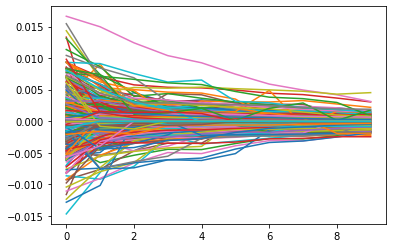

In [103]:
for j in range(len(dict_grads[0])):
    plt.plot([i for i in dict_grads.keys()] , [i[j] for i in dict_grads.values()])


In [66]:
len(dict_grads[0])

500

In [98]:
model.model_feature[0].weight.grad.shape

torch.Size([3, 1, 3, 3])